**Prediction models for the Taiwan dataset**

In [224]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### 1. data:

We start with loading the clean data we made previously

In [199]:
url = "https://raw.githubusercontent.com/Vincent2308/Corporate-Bankruptcy/refs/heads/main/data/clean/taiwan/taiwan.csv"
df = pd.read_csv(url)
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Current Liability to Current Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,1,0.390923,0.428314,0.435356,0.601457,0.601457,0.998969,0.796887,0.808809,0.302963,...,0.075475,0.728578,0.009219,0.622879,0.601453,0.833419,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.047775,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.028902,0.569389,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796630,0.808600,0.302963,...,0.025346,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,1,0.399844,0.451265,0.457733,0.591105,0.591105,0.998700,0.796967,0.808966,0.303350,...,0.067250,0.739555,0.003252,0.622929,0.591105,0.834697,0.281721,0.026697,0.564663,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.047725,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.026205,0.569389,0.035490


### 2. Splitting the dataset

Next we need to split the dataset into a training and test dataset. This is to make sure any model we make doesn't only work for the specific dataset we've used to make the model. We will use a 80/20 split for the training and testing dataset respectfully, the reasoning for this is specified in the Polish model notebook.

In [200]:
x = df.drop(columns=["Bankrupt?"])
y = df['Bankrupt?']

x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size = 0.2, stratify =y, random_state = 42)

### 3. Scaling
Next we will scale the data so all values in the collumns have mean 0 and a standard deviation of 1. We do this because some collumns have a much bigger range of values than others, these could disproportionality affact the model compared to collumns that have a smaller values. 

We only have to scale the *x* dataset because y are binairy values (0 for in business and 1 for bankrupt)

In [201]:
scaler = StandardScaler()

x_train_sc = scaler.fit_transform(x_train)
x_test_sc  = scaler.transform(x_test)

### 4. SMOTE

In [202]:
smote = SMOTE(random_state = 42)
x_train_sc_sm, y_train_sm, = smote.fit_resample(x_train_sc, y_train)

### 5. Evaluation

In [203]:
def evaluate_model(model, x_test_sc, y_test):
    # evaluate the mdodel based on the previoulsy chosen metrics
    y_pred = model.predict(x_test_sc)

    # gets the predicted probability the the sample belongs to bankrupt = 1
    y_prob = model.predict_proba(x_test_sc)[:,1]

    #metrics
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # print results
    print(f'Accuracy: {acc:.3f}')
    print(f'Precision: {pre:.3f}')
    print(f'Recall: {rec:.3f}')
    print(f'F1-Score: {f1:.3f}')
    print(f'AUC Score: {auc:.3f}')

    #plot
    RocCurveDisplay.from_estimator(model, x_test_sc, y_test)
    plt.show()

### 6. Altman Z-score

In [204]:
Z = (
    1.2 * df[" Working Capital to Total Assets"] +
    1.4 * df[" Retained Earnings to Total Assets"] +
    3.3 * df[" ROA(A) before interest and % after tax"] +
    1.0 * df[" Total Asset Turnover"]
)
df["Z-score"] = Z
roc_auc_score(y, df["Z-score"])

0.11553024562950309

### 8. Logistic Regression

##### 8.1 without SMOTE

Accuracy: 0.883
Precision: 0.202
Recall: 0.886
F1-Score: 0.329
AUC Score: 0.947


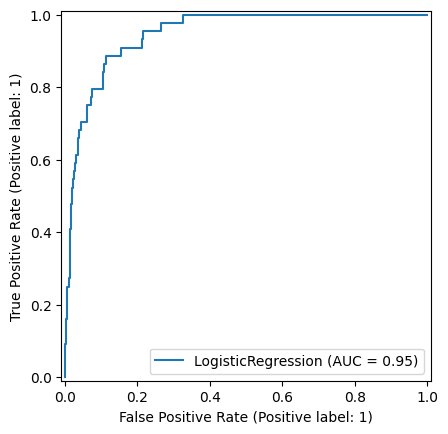

In [205]:
lr = LogisticRegression(max_iter = 500, class_weight = "balanced")
lr.fit(x_train_sc, y_train)
evaluate_model(lr, x_test_sc, y_test)

##### 8.2 Higher max iter

Accuracy: 0.883
Precision: 0.202
Recall: 0.886
F1-Score: 0.329
AUC Score: 0.947


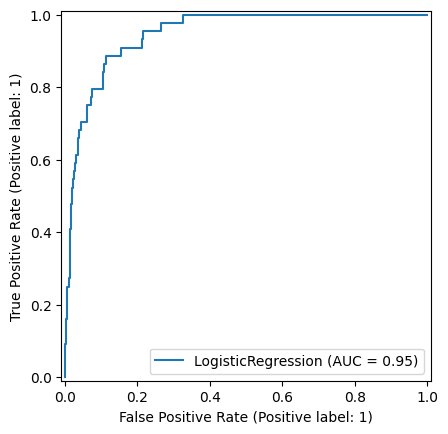

In [206]:
lr = LogisticRegression(max_iter = 500000, class_weight = "balanced")
lr.fit(x_train_sc, y_train)
evaluate_model(lr, x_test_sc, y_test)

##### 8.3 with SMOTE

Accuracy: 0.886
Precision: 0.206
Recall: 0.886
F1-Score: 0.335
AUC Score: 0.950


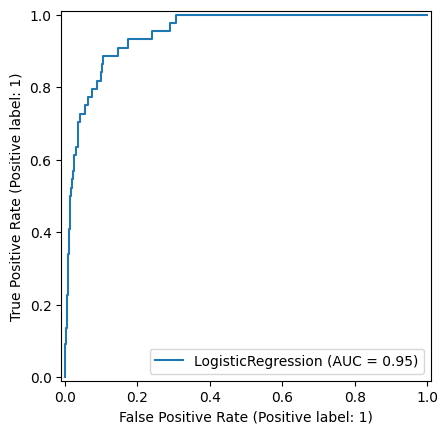

In [207]:
lr_sm = LogisticRegression(max_iter = 999999)
lr_sm.fit(x_train_sc_sm, y_train_sm)
evaluate_model(lr_sm, x_test_sc, y_test)

##### 8.4 Principal Component Analysis (PCA)

Accuracy: 0.968
Precision: 0.500
Recall: 0.114
F1-Score: 0.185
AUC Score: 0.920


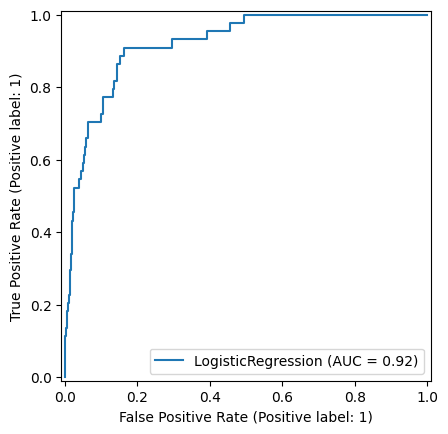

In [208]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
x_train_pca = pca.fit_transform(x_train_sc)
x_test_pca  = pca.transform(x_test_sc)

lr_pca = LogisticRegression()
lr_pca.fit(x_train_pca, y_train)
evaluate_model(lr_pca, x_test_pca, y_test)

##### 8.5 Principal Component Analysis (PCA) with SMOTE

Accuracy: 0.857
Precision: 0.161
Recall: 0.818
F1-Score: 0.270
AUC Score: 0.917


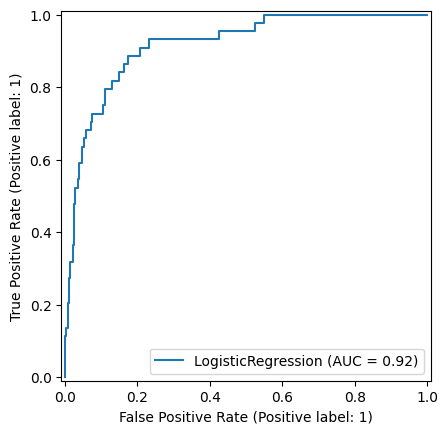

In [209]:
pca = PCA(n_components=1)
x_train_pca = pca.fit_transform(x_train_sc_sm)
x_test_pca = pca.transform(x_test_sc)

lr_pca_sm = LogisticRegression()
lr_pca_sm.fit(x_train_pca, y_train_sm)
evaluate_model(lr_pca_sm, x_test_pca, y_test)

### 9. Random forrest

##### 9.1 Random forrest without SMOTE

Accuracy: 0.973
Precision: 0.818
Recall: 0.205
F1-Score: 0.327
AUC Score: 0.945


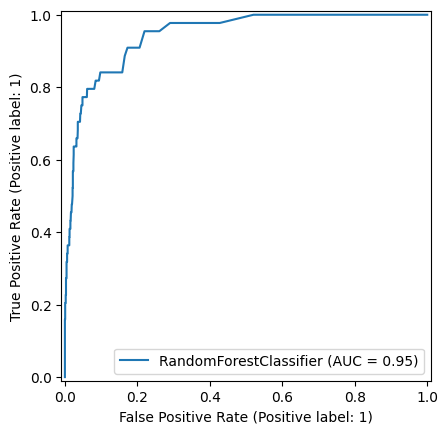

In [210]:
rf = RandomForestClassifier(n_estimators = 500, class_weight = "balanced", random_state = 42)
rf.fit(x_train_sc, y_train)
evaluate_model(rf, x_test_sc, y_test)

##### 9.2 Random forrest with SMOTE

Accuracy: 0.971
Precision: 0.558
Recall: 0.545
F1-Score: 0.552
AUC Score: 0.947


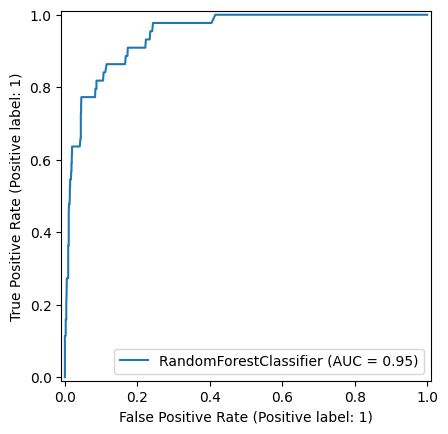

In [211]:
rf_sm = RandomForestClassifier(n_estimators = 500, random_state = 42)
rf_sm.fit(x_train_sc_sm, y_train_sm)
evaluate_model(rf_sm, x_test_sc, y_test)

##### 9.3 Random forrest with Linear Discriminant Analysis (LDA) and SMOTE

Accuracy: 0.856
Precision: 0.163
Recall: 0.841
F1-Score: 0.273
AUC Score: 0.916


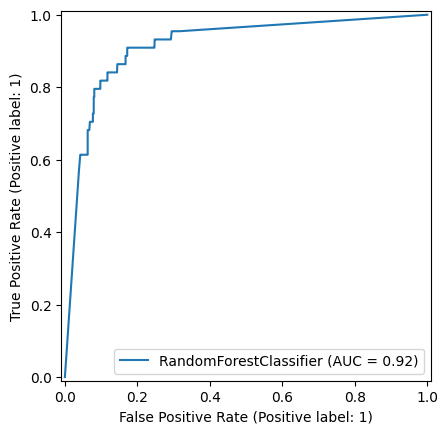

In [212]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(x_train_sc_sm, y_train_sm)
X_test_lda = lda.transform(x_test_sc)

rf_sm_lda = RandomForestClassifier(
    n_estimators=1000,
    random_state=42,
    n_jobs=-1
)

rf_sm_lda.fit(X_train_lda, y_train_sm)
evaluate_model(rf_sm_lda, X_test_lda, y_test)

##### 9.4 Random forrest with Linear Discriminant Analysis (LDA)

Accuracy: 0.955
Precision: 0.311
Recall: 0.318
F1-Score: 0.315
AUC Score: 0.814


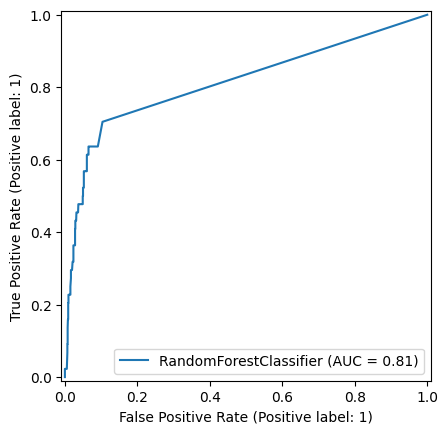

In [213]:
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(x_train_sc, y_train)
x_test_lda = lda.transform(x_test_sc)

rf_lda = RandomForestClassifier(
    n_estimators=1000,
    random_state=42,
    n_jobs=-1
)
rf_lda.fit(X_train_lda, y_train)

evaluate_model(rf_lda, x_test_lda, y_test)

### 10. K nearest neighbours

##### 10.1 without SMOTE

Accuracy: 0.966
Precision: 0.464
Recall: 0.295
F1-Score: 0.361
AUC Score: 0.707


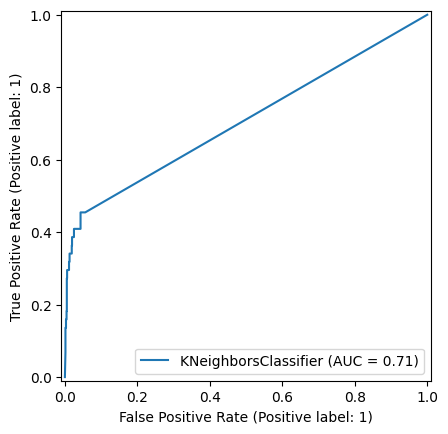

Accuracy: 0.968
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
AUC Score: 0.948


e:\Linux_Sync\sda\project\project_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


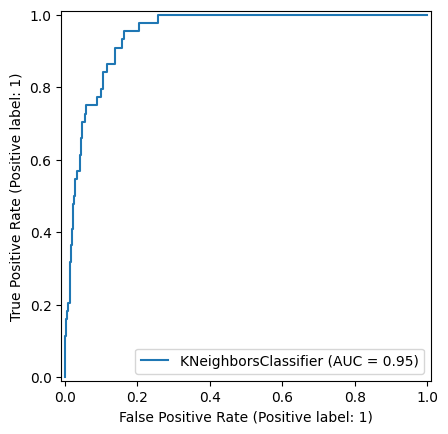

In [214]:
from collections import Counter

#----------Manual implementation of KNN----------
def evaluate_knn(preds, probs, y_test):
    acc = accuracy_score(y_test, preds)
    pre = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, probs)

    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {pre:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"AUC Score: {auc:.3f}")

    RocCurveDisplay.from_predictions(y_test, probs)
    plt.show()

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))

def knn_predict_one_with_prob(training_data, training_labels, test_point, k):
    distances = []
    for i in range(len(training_data)):
        dist = euclidean_distance(test_point, training_data[i])
        distances.append((dist, training_labels[i]))

    distances.sort(key=lambda x: x[0])
    k_nearest_labels = [label for _, label in distances[:k]]

    counter = Counter(k_nearest_labels)
    prob_1 = counter[1] / k

    pred = 1 if prob_1 >= 0.5 else 0
    return pred, prob_1

def knn_predict_many_with_prob(training_data, training_labels, test_data, k):
    preds = []
    probs = []
    for point in test_data:
        pred, prob = knn_predict_one_with_prob(training_data, training_labels, point, k)
        preds.append(pred)
        probs.append(prob)
    return np.array(preds), np.array(probs)

# for k in [1,3,5,7,25, 31, 41, 51]:
#     preds, probs = knn_predict_many_with_prob(x_train_sc_sm, y_train_sm, x_test_sc, k=10)
#     evaluate_knn(preds, probs, y_test)


#----------sklearn implementation of KNN----------
from sklearn.neighbors import KNeighborsClassifier

knn = {}
for k in [3, 99]:
    model = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)
    model.fit(x_train_sc, y_train)
    knn[str(k)] = model
    evaluate_model(knn[str(k)], x_test_sc, y_test)

### 10.2 KNN with SMOTE

Accuracy: 0.896
Precision: 0.178
Recall: 0.614
F1-Score: 0.276
AUC Score: 0.839


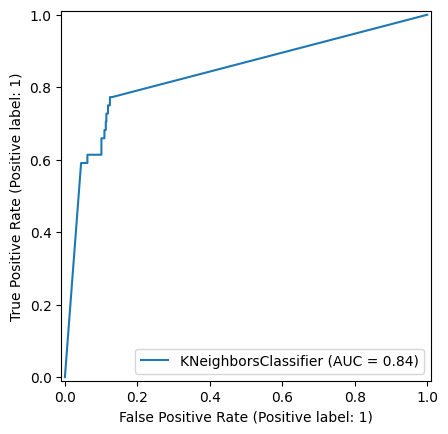

Accuracy: 0.828
Precision: 0.150
Recall: 0.932
F1-Score: 0.259
AUC Score: 0.940


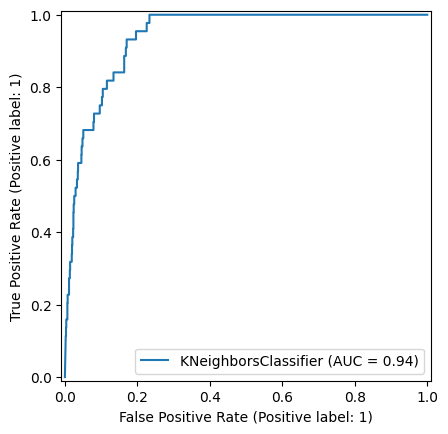

In [215]:
knn_sm = {}
for k in [3, 99]:
    model = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)
    model.fit(x_train_sc_sm, y_train_sm)
    knn_sm[str(k)] = model
    evaluate_model(knn_sm[str(k)], x_test_sc, y_test)

### 11. XGBoost

Accuracy: 0.968
Precision: 0.516
Recall: 0.364
F1-Score: 0.427
AUC Score: 0.956


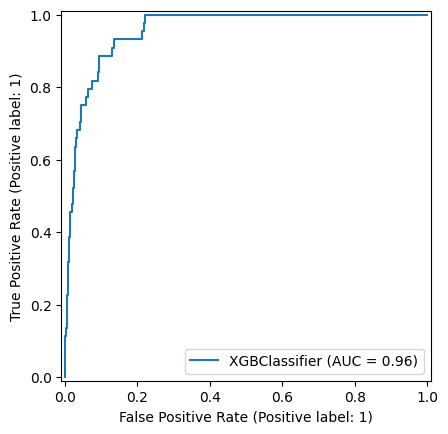

In [216]:
xgb = XGBClassifier(eval_metric = "logloss", random_state = 42)
xgb.fit(x_train_sc, y_train)
evaluate_model(xgb, x_test_sc, y_test)

Accuracy: 0.969
Precision: 0.522
Recall: 0.545
F1-Score: 0.533
AUC Score: 0.956


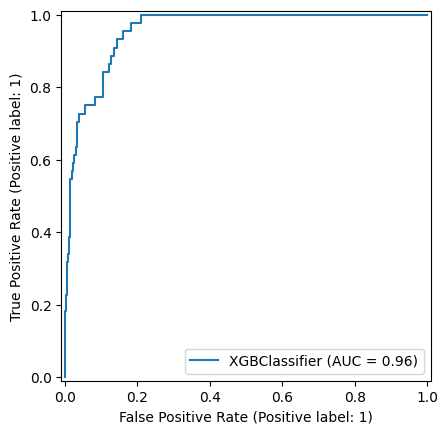

In [217]:
xgb_sm = XGBClassifier(eval_metric = "logloss", random_state = 42)
xgb_sm.fit(x_train_sc_sm, y_train_sm)
evaluate_model(xgb_sm, x_test_sc, y_test)

### 12. Features

In [218]:
coefficients = lr.coef_[0]
odds_ratios = np.exp(coefficients)

coefficients_df = pd.DataFrame({
'Feature' : x.columns,
"Coefficients" : coefficients,
"Odds ratio" : odds_ratios
})

print(coefficients_df.sort_values(by="Coefficients", ascending=False))
coefficients_df.head(15)

                                              Feature  Coefficients  \
2    ROA(B) before interest and depreciation after...      2.368080   
1              ROA(A) before interest and % after tax      1.691626   
6                           Pre-tax net Interest Rate      1.515168   
41                   Operating profit/Paid-in capital      1.359729   
36                                       Debt ratio %      1.073001   
..                                                ...           ...   
84                         Net Income to Total Assets     -1.254269   
20                         Revenue Per Share (Yuan ¥)     -1.318296   
89                                Liability to Equity     -1.430672   
18            Persistent EPS in the Last Four Seasons     -1.783601   
0    ROA(C) before interest and depreciation befor...     -2.525645   

    Odds ratio  
2    10.676870  
1     5.428300  
6     4.550184  
41    3.895138  
36    2.924140  
..         ...  
84    0.285284  
20    0.267

,Feature,Coefficients,Odds ratio
0,ROA(C) before interest and depreciation befor...,-2.525645,0.080007
1,ROA(A) before interest and % after tax,1.691626,5.428300
2,ROA(B) before interest and depreciation after...,2.368080,10.676870
3,Operating Gross Margin,-0.043893,0.957057
4,Realized Sales Gross Margin,0.096540,1.101353
5,Operating Profit Rate,-0.009864,0.990184
6,Pre-tax net Interest Rate,1.515168,4.550184
7,After-tax net Interest Rate,-0.662006,0.515815
8,Non-industry income and expenditure/revenue,0.359473,1.432575
9,Continuous interest rate (after tax),-0.723286,0.485155


In [219]:
fi_rf = pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False)

fi_rf.head(15)

Persistent EPS in the Last Four Seasons              0.050818
Borrowing dependency                                 0.048835
Net worth/Assets                                     0.039828
Net Income to Total Assets                           0.039260
Continuous interest rate (after tax)                 0.037472
Total debt/Total net worth                           0.035070
Total income/Total expense                           0.035009
Equity to Liability                                  0.034387
Retained Earnings to Total Assets                    0.033263
Debt ratio %                                         0.028502
Net profit before tax/Paid-in capital                0.026764
ROA(B) before interest and depreciation after tax    0.024592
Per Share Net profit before tax (Yuan ¥)             0.024284
Liability to Equity                                  0.023835
After-tax net Interest Rate                          0.022354
dtype: float64

In [220]:
fi_xgb = pd.Series(xgb.feature_importances_,index=x.columns).sort_values(ascending=False)

fi_xgb.head(15)

Net Income to Stockholder's Equity             0.549960
Equity to Liability                            0.050432
Persistent EPS in the Last Four Seasons        0.037500
Borrowing dependency                           0.028992
Net Income to Total Assets                     0.021915
Quick Ratio                                    0.015197
Total debt/Total net worth                     0.012387
Retained Earnings to Total Assets              0.008693
Tax rate (A)                                   0.008371
Net Value Per Share (B)                        0.008326
Cash Flow Per Share                            0.008132
Debt ratio %                                   0.007299
Operating profit/Paid-in capital               0.007012
Non-industry income and expenditure/revenue    0.006718
Total Asset Turnover                           0.006425
dtype: float32

### 13. Compare models

In [221]:
results = []

def add_result(name, model, data):
    # evaluate the mdodel based on the previoulsy chosen metrics
    y_pred = model.predict(data)

    # gets the predicted probability the the sample belongs to bankrupt = 1
    y_prob = model.predict_proba(data)[:,1]

    results.append({"Model": name,"Auc": roc_auc_score(y_test, y_prob),
        "Recall": recall_score(y_test, y_pred),"Precision": precision_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

In [222]:
add_result("Logistic regression", lr, x_test_sc)
add_result("Logistic regression (SMOTE)", lr_sm, x_test_sc)

add_result("RandomForest", rf, x_test_sc)
add_result("RandomForest (SMOTE)", rf_sm, x_test_sc)

add_result("XGBoost", xgb, x_test_sc)
add_result("XGBoost (SMOTE)", xgb_sm, x_test_sc)

add_result("KNN k=3", knn_sm["3"], x_test_sc)
add_result("KNN k=3 (SMOTE)", knn_sm["3"], x_test_sc)

add_result("KNN k=99", knn["99"], x_test_sc)
add_result("KNN k=99 (SMOTE)", knn_sm["99"], x_test_sc)

add_result("Logistic regression PCA", lr_pca, x_test_lda)
add_result("Logistic regression PCA (SMOTE)", lr_pca_sm, x_test_lda)

add_result("Random forrest LDA", rf_lda, x_test_lda)
add_result("Random forrest LDA (SMOTE)", rf_sm_lda, x_test_lda)


e:\Linux_Sync\sda\project\project_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\Linux_Sync\sda\project\project_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [223]:
results_df = pd.DataFrame(results)
results_df

,Model,Auc,Recall,Precision,F1
0,Logistic regression,0.946660,0.886364,0.202073,0.329114
1,Logistic regression (SMOTE),0.949862,0.886364,0.206349,0.334764
2,RandomForest,0.945231,0.204545,0.818182,0.327273
3,RandomForest (SMOTE),0.946944,0.545455,0.558140,0.551724
4,XGBoost,0.956216,0.363636,0.516129,0.426667
5,XGBoost (SMOTE),0.955906,0.545455,0.521739,0.533333
6,KNN k=3,0.839187,0.613636,0.177632,0.275510
7,KNN k=3 (SMOTE),0.839187,0.613636,0.177632,0.275510
8,KNN k=99,0.947641,0.000000,0.000000,0.000000
9,KNN k=99 (SMOTE),0.940401,0.931818,0.150183,0.258675
